# Quick start with HTL API

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
pip install signal-ocean

In [1]:
signal_ocean_api_key = '' #replace with your subscription key

## Example 1 - Plotting a supply trend
In this demo is presented how a user can query with a few lines of code the HTL API and generate an aggegated view on the supply trend.

The data frame format makes it very easy to generate a supply trend plot.

We'll generate a supply trend from 10 days, but we'll also filter the vessel list by looking for vessels that:
- are pushed, poss_pushed,
- have a market deployment type of "Relet" or "Spot",
- their commercial status is available, cancelled or failed,
- are crude oil tankers (their vessel subclass is "Dirty"),
- their AIS information is no older than 5 days.

Filtering can be achieved by creating an instance of a `VesselFilter` and passing it to the `get_historical_tonnage_list` method. A `VesselFilter` meeting the above criteria will look as follows:

In [2]:
from datetime import date, timedelta,time,datetime
from signal_ocean import PortAPI, VesselClassAPI,PortFilter,VesselClassFilter,Connection
from signal_ocean.historical_tonnage_list import VesselFilter, PushType, MarketDeployment, CommercialStatus, VesselSubclass
from signal_ocean.historical_tonnage_list import HistoricalTonnageListAPI

connection = Connection(signal_ocean_api_key)

port_api = PortAPI(connection)
vessel_class_api = VesselClassAPI(connection)
htl_api = HistoricalTonnageListAPI(connection)
vessel_class = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like='aframax'))[0]
port = port_api.get_ports(PortFilter(name_like='escravos'))[0]
laycanEndInDays = 20
start_date = datetime.utcnow().date() - timedelta(days=5)
end_date = datetime.utcnow().date()

vessel_filter = VesselFilter(
    push_types=[PushType.PUSHED, PushType.PUSHED_POSS],
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    commercial_statuses=[CommercialStatus.AVAILABLE, CommercialStatus.CANCELLED, CommercialStatus.FAILED],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5
)


currentHour = datetime.utcnow().time().hour
last_existing_snapshot = (currentHour // 6) *6

htl_for_supply_trend = htl_api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycanEndInDays,
    start_date,
    end_date,
    vessel_filter=vessel_filter,
    time=time(hour=last_existing_snapshot)
)

supply_trend_data_frame = htl_for_supply_trend.to_data_frame()

supply_trend_data_frame

name vessel_class ice_class  \
date                      imo                                                
2021-05-14 12:00:00+00:00 9802152        Ionic Anax      Aframax       NaN   
                          9741815           Primero      Aframax       NaN   
                          9276597      Minerva Lisa      Aframax        1C   
                          9348479       Aegean Myth      Aframax       NaN   
                          9338917    Aegean Harmony      Aframax       NaN   
...                                             ...          ...       ...   
2021-05-09 12:00:00+00:00 9370848     Anafi Warrior      Aframax       NaN   
                          9787170  Minerva Karteria      Aframax       NaN   
                          9829100    Tyrrhenian Sea      Aframax        1C   
                          9331153            Alhani      Aframax        1A   
                          9656890      Fos Hamilton      Aframax       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-05-14 12:00:00+00:00 9802152        2017      114720          250.00   
                          9741815        2016      106329          228.00   
                          9276597        2004      103755          243.57   
                          9348479        2006      115838          248.95   
                          9338917        2007      115824          248.93   
...                                       ...         ...             ...   
2021-05-09 12:00:00+00:00 9370848        2009      107593          243.80   
                          9787170        2018      114780          250.01   
                          9829100        2019      114218          249.80   
                          9331153        2007      114795          248.99   
                          9656890        2013      105408          244.15   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-05-14 12:00:00+00:00 9802152               44    Dirty   
                          9741815               42    Dirty   
                          9276597               42    Dirty   
                          9348479               44    Dirty   
                          9338917               44    Dirty   
...                                            ...      ...   
2021-05-09 12:00:00+00:00 9370848               42    Dirty   
                          9787170               44    Dirty   
                          9829100               44    Dirty   
                          9331153               44    Dirty   
                          9656890               42    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-05-14 12:00:00+00:00 9802152                           Relet   
                          9741815                            Spot   
                          9276597                            Spot   
                          9348479                            Spot   
                          9338917                            Spot   
...                                                           ...   
2021-05-09 12:00:00+00:00 9370848                            Spot   
                          9787170                            Spot   
                          9829100                            Spot   
                          9331153                           Relet   
                          9656890                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-05-14 12:00:00+00:00 9802152                  Pushed  ...   
                          9741815                  Pushed  ...   
                          9276597               

Now, we can generate the plot:

<AxesSubplot:xlabel='date', ylabel='Vessel count'>

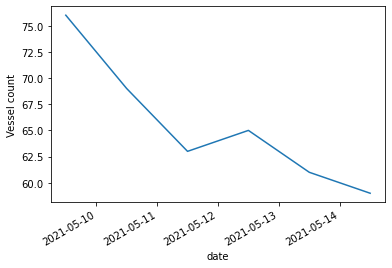

In [3]:
from signal_ocean.historical_tonnage_list import IndexLevel

supply_trend = supply_trend_data_frame.groupby(IndexLevel.DATE, sort=True).size()
plot = supply_trend.plot()
plot.set_ylabel('Vessel count')

plot

## Example 2 - Generating an Excel sheet
The data frame can be easily saved as an Excel file by using Pandas's built-in `to_excel()` function.

Before we do that, we need to remove all the time zone information from all the timestamps in the data frame. This is because Excel does not support storing time zone information along with timestamps. However, Signal Ocean's SDK always provides time zone information to make all timestamp-based computation unambiguous.

In [4]:
from signal_ocean.historical_tonnage_list import Column

without_time_zones = (
    supply_trend_data_frame
        .reset_index()
        .astype({ IndexLevel.DATE: 'datetime64[ns]', Column.OPEN_DATE: 'datetime64[ns]', Column.ETA: 'datetime64[ns]', Column.LATEST_AIS: 'datetime64[ns]'})
        .set_index([IndexLevel.DATE, IndexLevel.IMO])
 )

Now, we can generate the Excel file:

In [5]:
without_time_zones.to_excel('simpleDemo.xlsx')